# Исследование эффективности привлечения пользователей в приложение


В нашем распоряжении данные о пользователях развлекательного приложения Procrastinate Pro+, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta

In [2]:
pd.set_option('chained_assignment', None)

In [3]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Исследуем таблицу visits:

In [4]:
visits.info()
visits.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


0

Пропусков, дупликатов нет. Требуется переименовать столбцы и изменить формат дат.

In [5]:
visits.columns=['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Исследуем таблицу orders:

In [6]:
orders.info()
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


0

Пропусков, дупликатов нет. Требуется переименовать столбцы и изменить формат дат.

In [7]:
orders.columns=['user_id', 'event_dt', 'revenue']
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Исследуем таблицу costs:

In [8]:
costs.info()
costs.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


0

Пропусков, дубликатов нет. Требуется переименовать столбцы и изменить формат дат.

In [9]:
costs = costs.rename(columns={'Channel':'channel'})
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

**Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.**

In [18]:
profiles = get_profiles(visits, orders, None, costs)

In [19]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [20]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [21]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

Таблица хранит данные пользователей, привлечённых с 1 мая по 27 октября 2019 года.

**Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.**

In [22]:
profiles.groupby('region').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


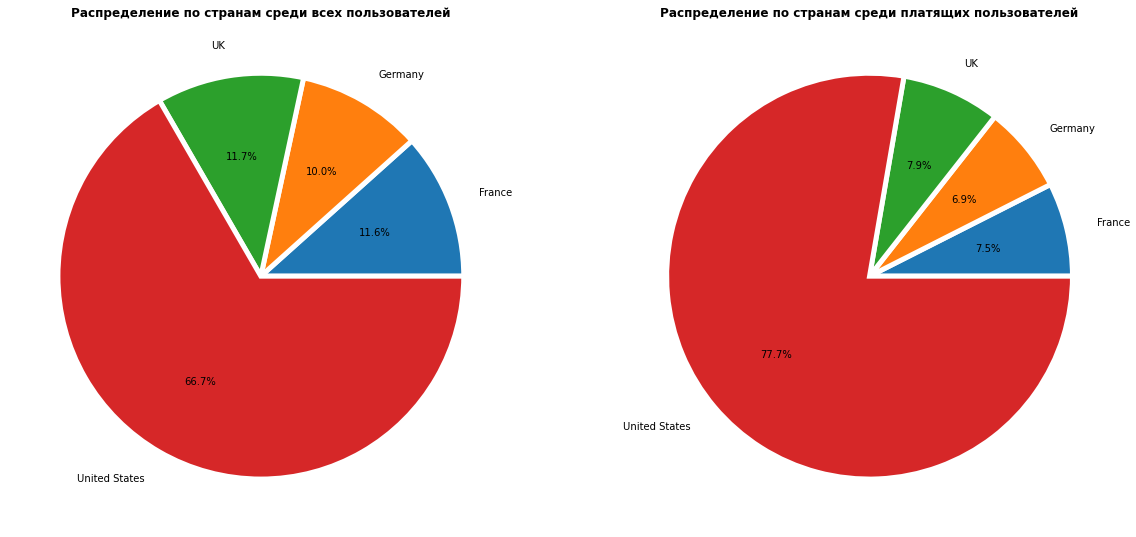

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 25))

ax1.pie(profiles.groupby('region').agg({'user_id':'nunique'}).reset_index()['user_id'],
        labels=profiles.groupby('region').agg({'user_id':'nunique'}).reset_index()['region'],
        labeldistance=1.15, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }, autopct='%1.1f%%')
ax1.set_title('Распределение по странам среди всех пользователей', fontweight='bold')

ax2.pie(profiles.query('payer == True').groupby('region').agg({'user_id':'nunique'}).reset_index()['user_id'],
       labels=profiles.query('payer == True').groupby('region').agg({'user_id':'nunique'}).reset_index()['region'],
       labeldistance=1.15, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }, autopct='%1.1f%%')
ax2.set_title('Распределение по странам среди платящих пользователей', fontweight='bold')

plt.show()

Больше всего в приложение приходят из США. Из Великобритании, Германии, Франции пользователей примерно одинаковое количество. Кроме того, из всех пользователей из США почти 7%  платящих, это самый большой процент. У Великобритании, Германии, Франции процент платящих пользователей около 4%. Это еще больше увеличивает долю пользователей из США среди платящих пользователей по сравнению со всеми пользователями. 

**Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.**

In [24]:
profiles.groupby('device').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


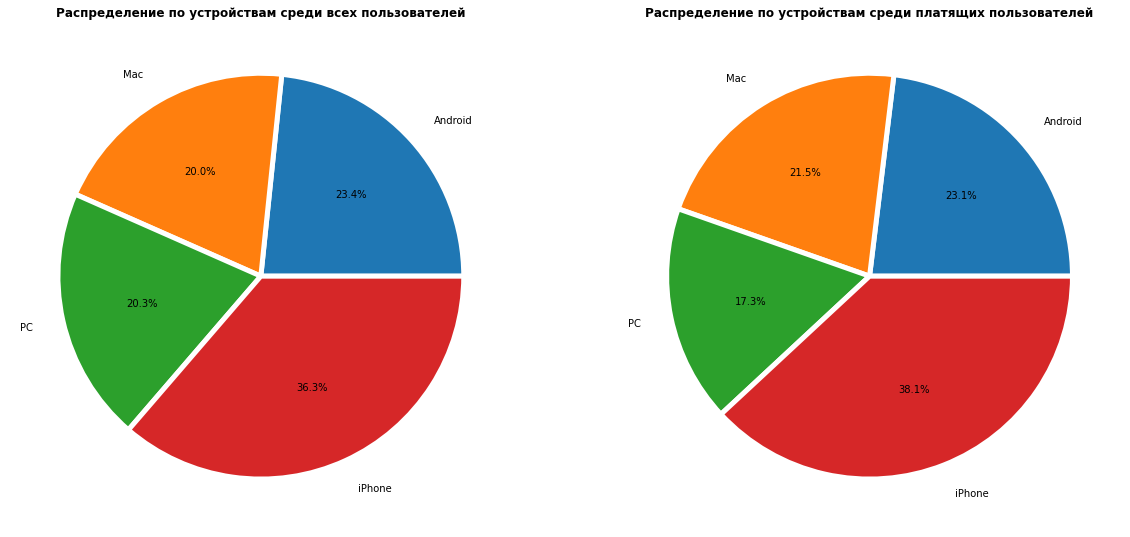

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 25))

ax1.pie(profiles.groupby('device').agg({'user_id':'nunique'}).reset_index()['user_id'],
        labels=profiles.groupby('device').agg({'user_id':'nunique'}).reset_index()['device'],
        labeldistance=1.15, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }, autopct='%1.1f%%')
ax1.set_title('Распределение по устройствам среди всех пользователей', fontweight='bold')

ax2.pie(profiles.query('payer == True').groupby('device').agg({'user_id':'nunique'}).reset_index()['user_id'],
       labels=profiles.query('payer == True').groupby('device').agg({'user_id':'nunique'}).reset_index()['device'],
       labeldistance=1.15, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }, autopct='%1.1f%%')
ax2.set_title('Распределение по устройствам среди платящих пользователей', fontweight='bold')

plt.show()

Пользователи с IPhone составляют 36.3% от всех пользователей и являются самой большой долей. Остальные устройства отстают: у Android - 23.4%, у PC и Mac примерно одинаковые доли - 20.3% и 20.0% соответственно. Процет платящих пользователей больше всего у Mac - 6.4%, не сильно отстает IPhone - 6.2%, у Android - 5.9%, в отстающих PC с 5%.  

**Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.**

In [26]:
profiles.groupby('channel').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


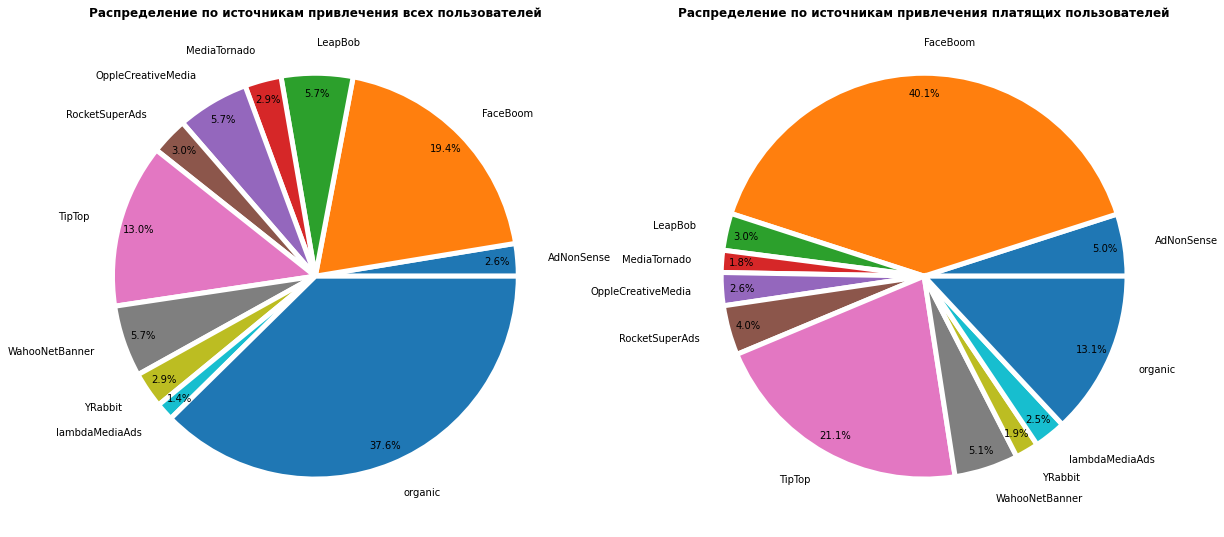

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 25))

ax1.pie(profiles.groupby('channel').agg({'user_id':'nunique'}).reset_index()['user_id'],
        labels=profiles.groupby('channel').agg({'user_id':'nunique'}).reset_index()['channel'],
        labeldistance=1.15, pctdistance=0.9,  wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }, autopct='%1.1f%%')
ax1.set_title('Распределение по источникам привлечения всех пользователей', fontweight='bold')

ax2.pie(profiles.query('payer == True').groupby('channel').agg({'user_id':'nunique'}).reset_index()['user_id'],
       labels=profiles.query('payer == True').groupby('channel').agg({'user_id':'nunique'}).reset_index()['channel'],
       labeldistance=1.15, pctdistance=0.9, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }, autopct='%1.1f%%')
ax2.set_title('Распределение по источникам привлечения платящих пользователей', fontweight='bold')

plt.show()

Среди всех пользователей больше всего привлечено органической выдачей - 37.6%, на втором месте FaceBoom - 19.4%, на третьем TipTop - 13.0%. Однако всего 2% органических пользователей начинают платить, это худший результат. Лучше всего конвертируются в плательщиком пользователи пришедшие из FaceBoom - 12.2%, AdNonSense - 11.3%, lambdaMediaAds - 10.5%. Таким образом, среди платящих пользователей больше всего вредставлены пользователи из FaceBoom - 40.1%, TipTop - 21.1%, Organic опускается на третье место - 13.1%.

### Маркетинг


**Общая сумма расходов на маркетинг:**

In [28]:
costs['costs'].sum()

105497.30000000002

**Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.**

In [29]:
channel_cost=costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False).reset_index()
channel_cost

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


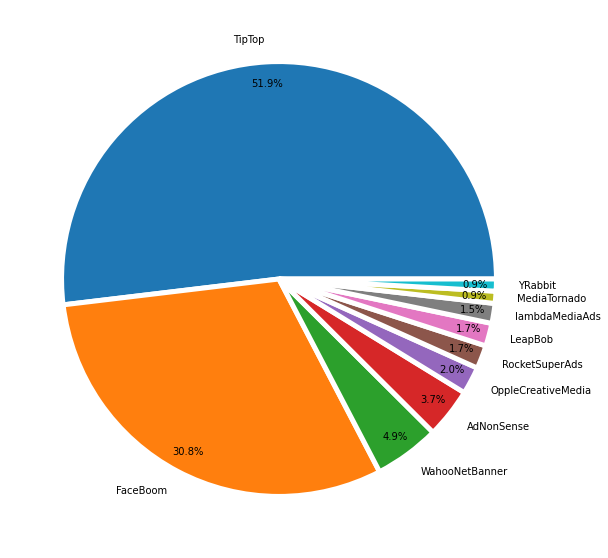

In [30]:
fig = plt.figure(figsize=(10, 10))
plt.pie(channel_cost['costs'],
        labels=channel_cost['channel'],
        labeldistance=1.1, pctdistance=0.9,  wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }, autopct='%1.1f%%')
plt.show()

Больше половины рекламного бюджета 51.9% потратили на TipTop. На втором месте FaceBoom c 30.8% бюджета. У остальных источников куски "пирога" суммарно менее 20%.

**Построим визуализацию динамики изменения расходов во времени по неделям по каждому источнику.**

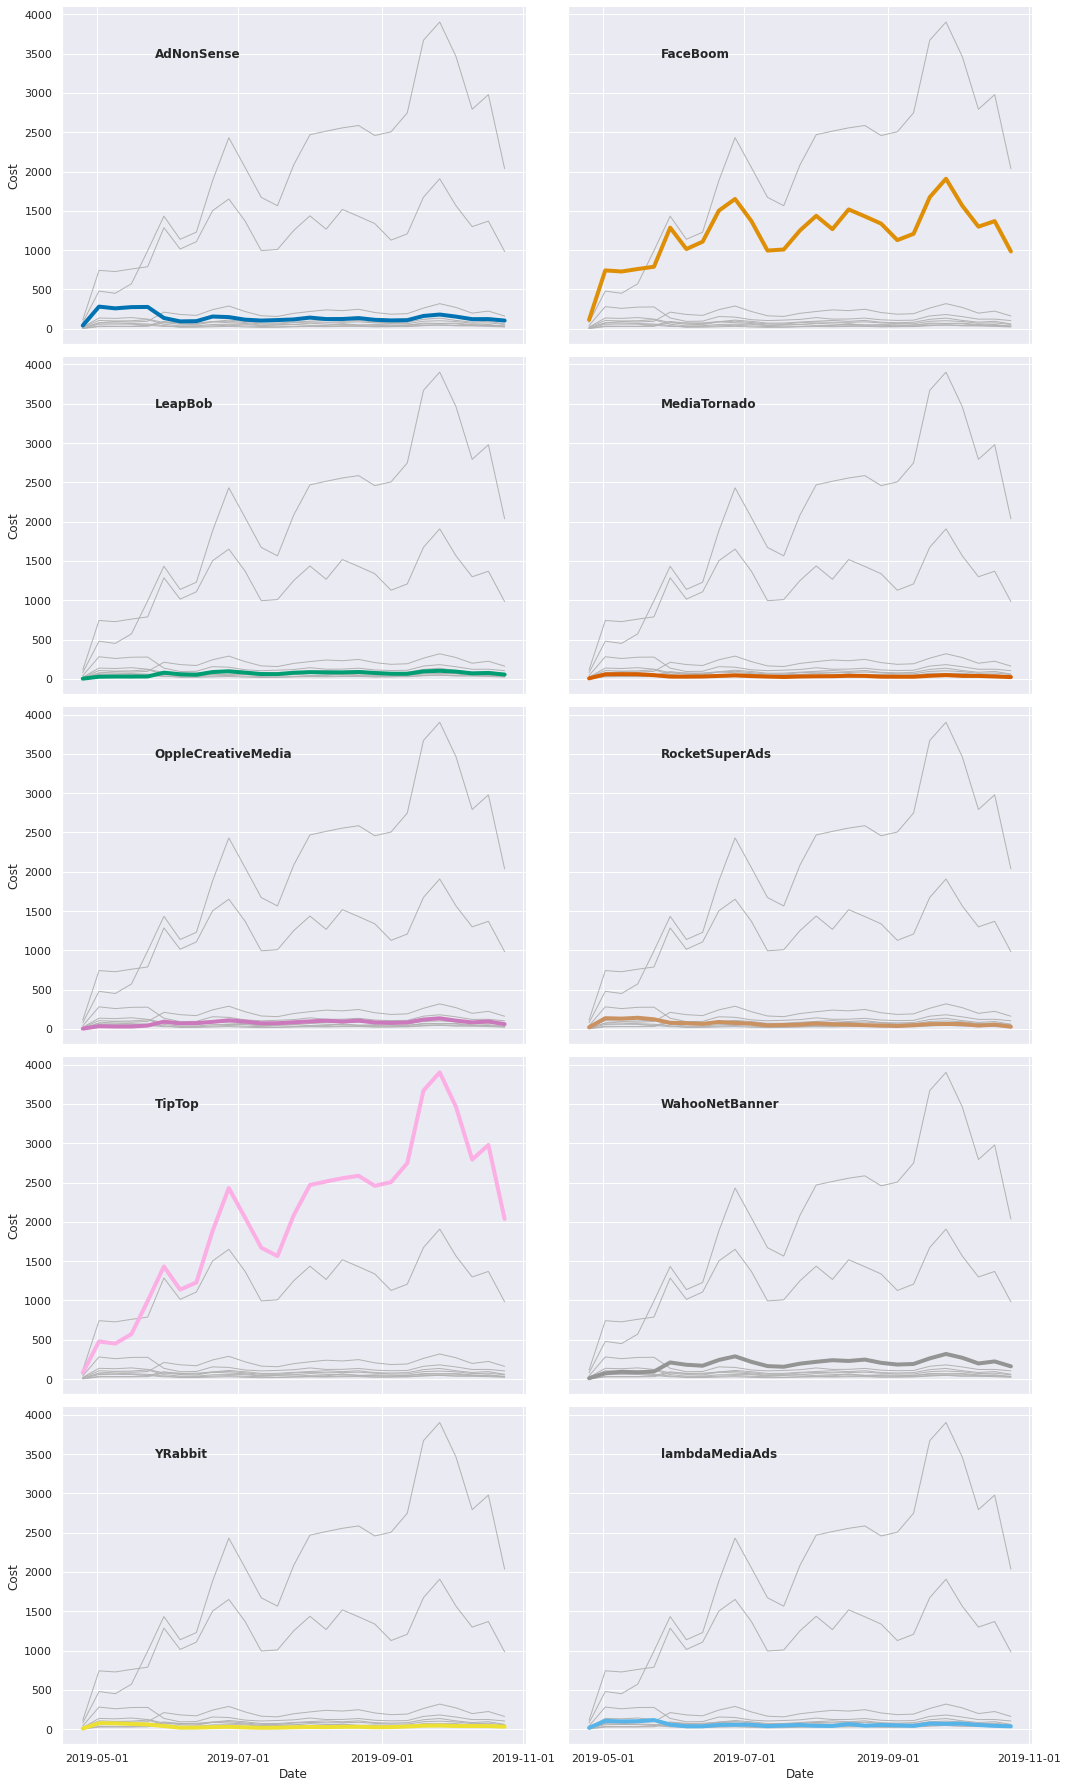

In [31]:
profiles['week'] = profiles['dt'].astype('datetime64[W]')
sum_costs = profiles[profiles['channel']!='organic'].groupby(['channel', 'week'])['acquisition_cost'].sum().reset_index()

sns.set_theme(style="darkgrid")
costs_plot = sns.relplot(
    data=sum_costs,
    x="week", y="acquisition_cost", col="channel", hue="channel",
    kind="line", palette="colorblind", linewidth=4, zorder=5,
    col_wrap=2, height=5, aspect=1.5, legend=False,
)

for channel, ax in costs_plot.axes_dict.items():
    ax.text(.2, .85, channel, transform=ax.transAxes, fontweight="bold")

    sns.lineplot(
        data=sum_costs, x="week", y="acquisition_cost", units="channel",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

ax.set_xticks(ax.get_xticks()[::2])

costs_plot.set_titles("")
costs_plot.set_axis_labels("Date", "Cost")
costs_plot.tight_layout()


 
Анализируя суммарные расходы по неделям, можем подтвердить, что в основном рекламный бюджет тратится на TipTop и FaceBoom. Кроме того, наблюдаем рост расходов от месяца к месяцу вплоть до октября и далее сокращение расходов в последнем месяце. Зададимся вопросом: не деньги ли кончаются из-за неэффективного расходования бюджета?

    
**Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) по всему проекту и из каждого источника.**

In [32]:
profiles['acquisition_cost'].mean()

0.7032778251826568

In [33]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717



Средняя стоимость привлечения по проекту - 1.13$. Самая большая средняя стоимость привлечения у TipTop, она более чем в два раза больше средней стоимости по проекту. А стоимость привлечения у FaceBoom примерно равняется средней и не сильно больше, чем у ближайших конкурентов, далее от канала к каналу стоимость снижается постепенно.

**Построим визуализацию динамики изменения CAC во времени по неделям по каждому источнику.**

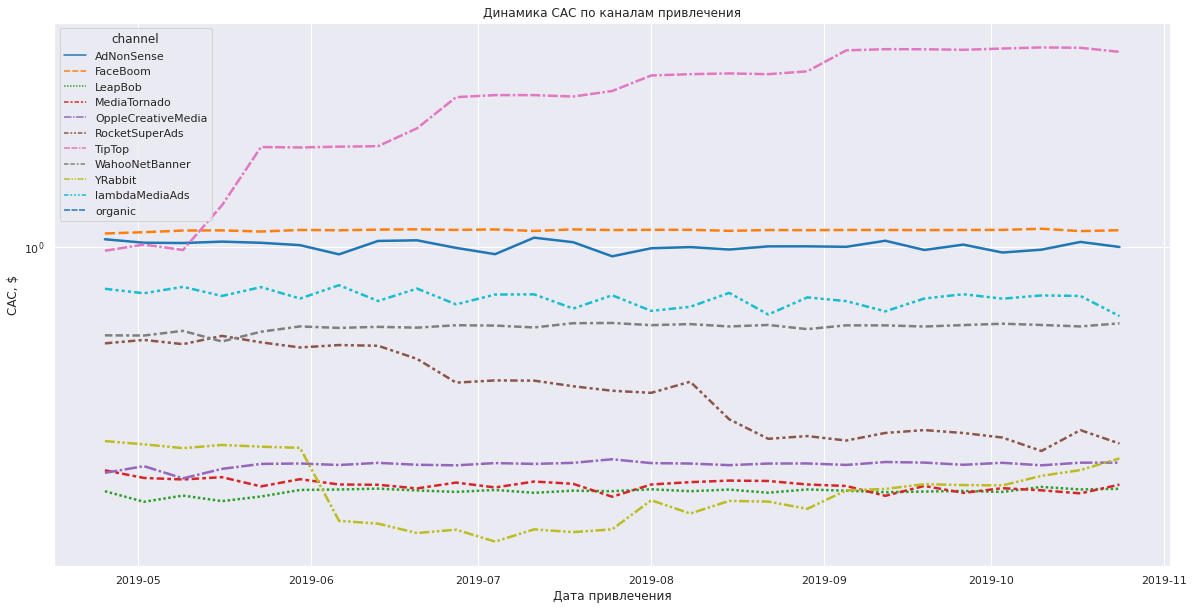

In [34]:
fig = plt.figure(figsize=(20, 10))
sns.lineplot(data=profiles.pivot_table(index='week', columns='channel', values='acquisition_cost', aggfunc='mean'), 
             palette="tab10", linewidth=2.5).set_yscale("log") #построим график, применив логарифметическую шкалу
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Самую стабильную стоимость привлечения показывает FaceBoom. У TipTop стоимость привлечения значительно увеличивается примерно каждый месяц. Подешевела CAC только у RocketSuperAds. У остальных платформ стоимость привлечения незначительно колеблется. 

### Оценим окупаемость рекламы


**Проанализируем окупаемость рекламы. На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Исключим из анализа органических пользователей, так как они будут искажать результаты анализа.**

In [35]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа
profiles = profiles[profiles['channel']!='organic']

**Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.**

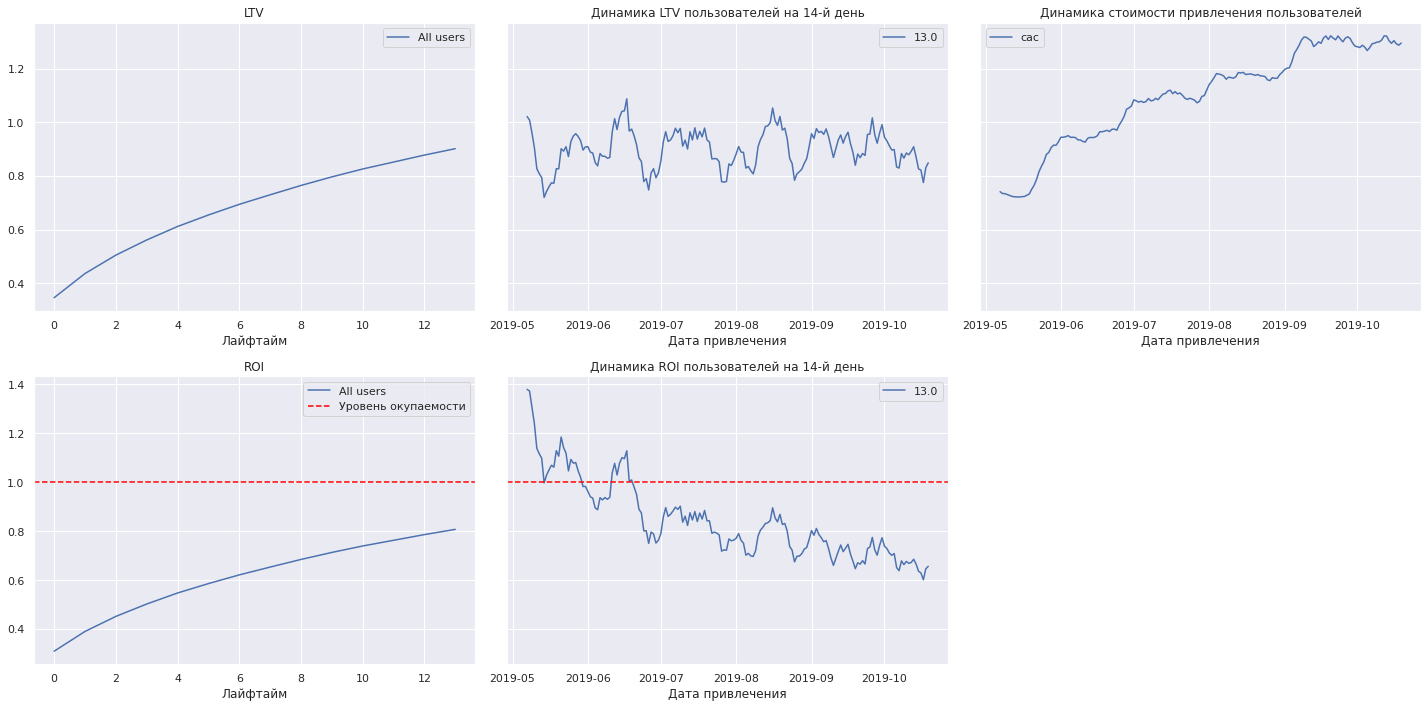

In [36]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Реклама не окупается. ROI к концу второй недели едва перевалил за 80%. Динамика ROI имеет тенденцию к снижению. Динамика LTV имеет пики и спады, что свойственно периодам рекламных компаний, однако имеет относительную стабильность, значит проблема не в пользователях. А вот CAC  с течением времени увеличивается. 

Бизнес со временем становится все убыточнее из-за постоянного увеличения стоимости привлечения пользователей.

**Проверим конверсию пользователей и динамику её изменения с разбивкой по устройствам. То же самое сделаем с удержанием пользователей.**

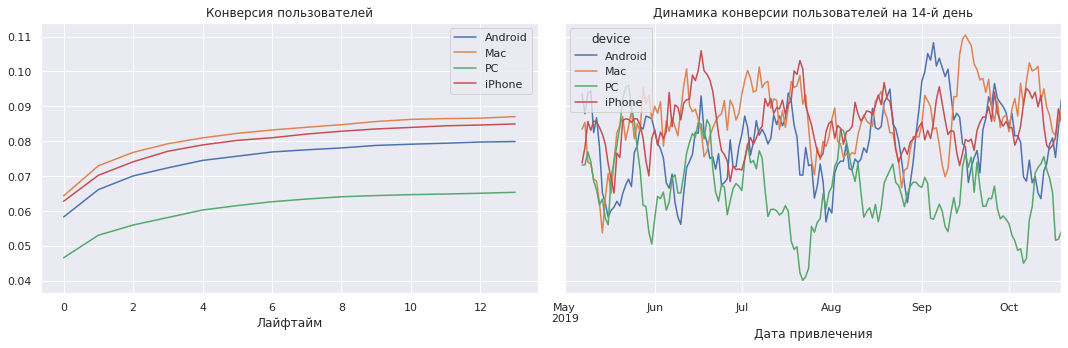

In [37]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия у пользователей PC ниже, чем у остальных девайсов, будем ожидать и меньшую цену за рекламу на PC

**Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

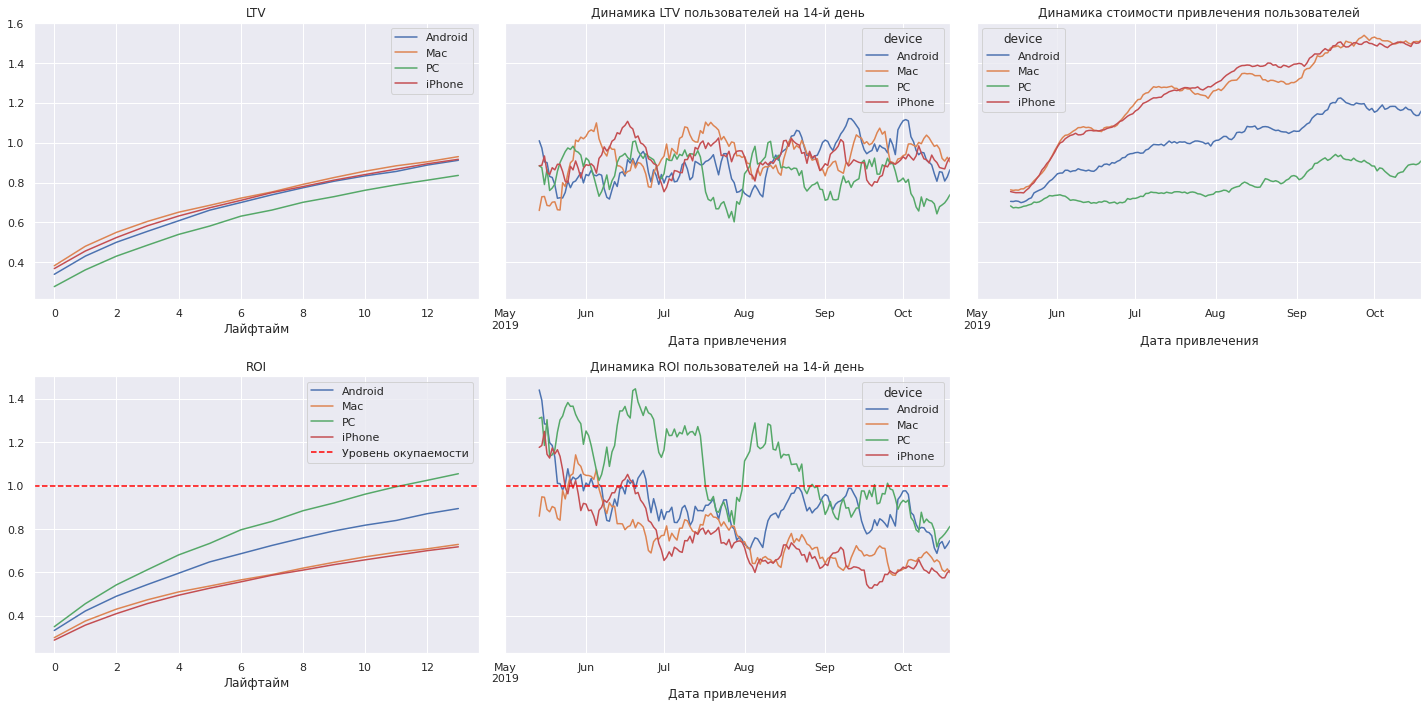

In [38]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Картина с разбивкой по устройствам повторяем общую. Хоть реклама на PC к концу второй недели окупилась (если брать весь период), однако в динамике мы видим, что и на PC цены привлечения растут и ROI  в последние месяцы показывает убточность. Флагманами  в росте стоимости привлечения являются Mac и iPhone.

**Построим удержание с разбивкой по устройствам**

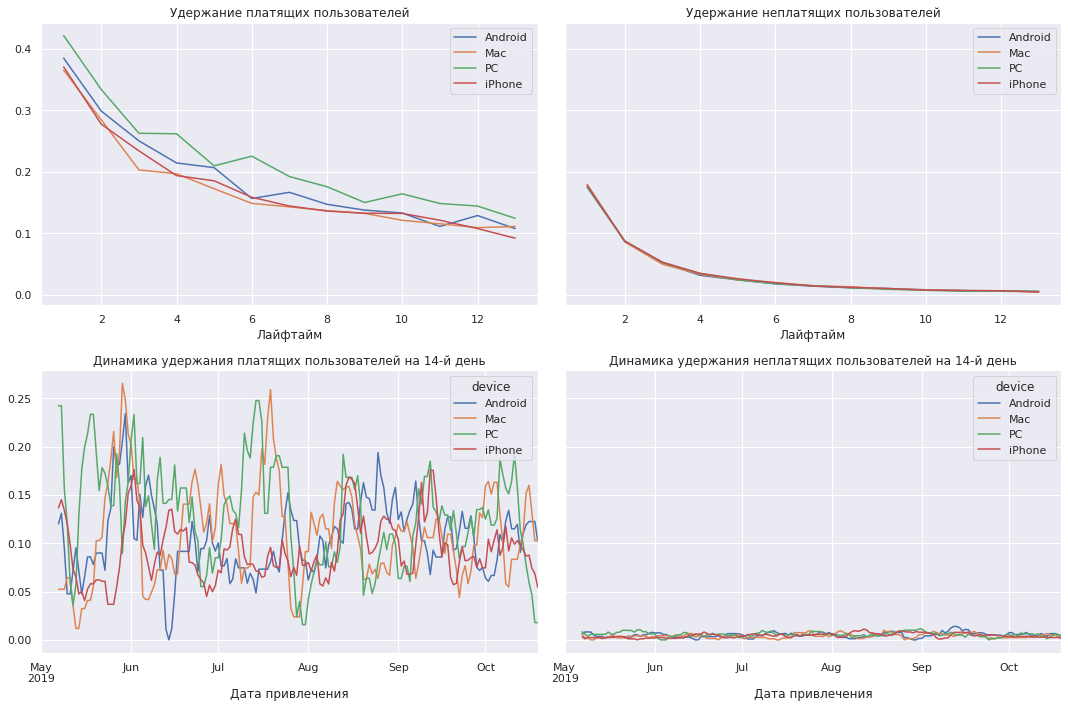

In [39]:
# смотрим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей PC несильно, но лучше, чем у других платформ. То есть реклама на PC хуже конвертируется, но имеет ниже стоимость и лучше удержание пользователей.

**Проверим конверсию пользователей и динамику её изменения с разбивкой по странам. То же самое сделаем с удержанием пользователей.**

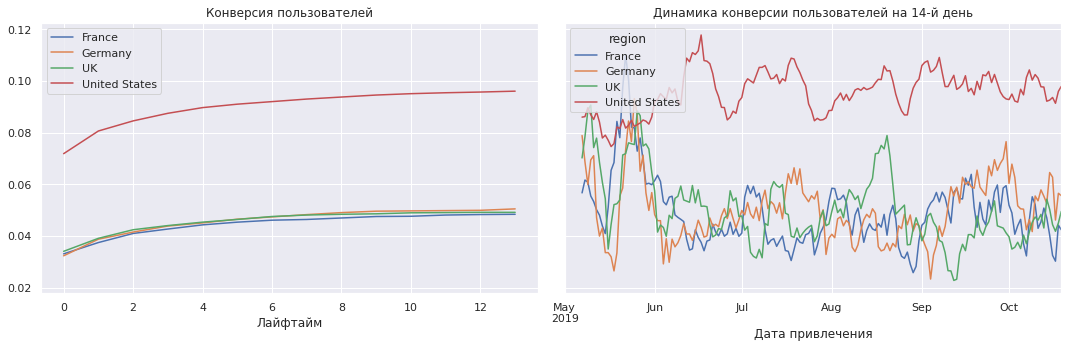

In [40]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей из США значительно лучше, чем у других стран. Ожидаем, что и цена на рынке США будет выше.

**Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

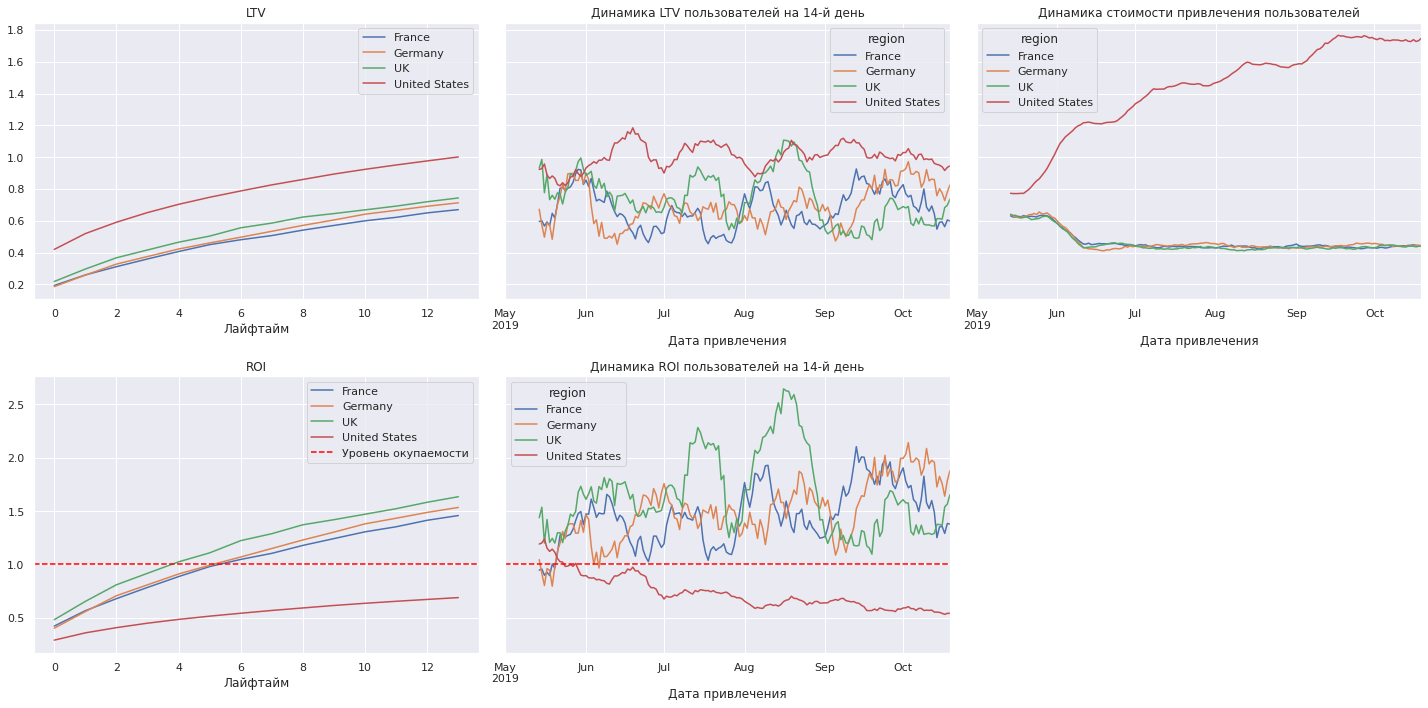

In [41]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Визуализировав разбивку по странам можем сделать вывод - во всех наших проблемах виновата Америка :)

Реклама во Франции, Германии и Великобритании стабильно окупается к концу первой недели, так как LTV более менее стабилен, а CAC даже немного упал в июне. Реклама в Америке не окупается, LTV в динамике стабилен, выше, чем у других стран, как мы помним из предыдущего исследования и конверсия у США выше, однако стоимость привлечения показывает постоянный рост, что тянет ROI c каждым месяцем все ниже. В итоге реклама в США оказалась переоценена, ее стоимость выше, чем мы можем получить от нее.

**Построим удержание с разбивкой по странам**

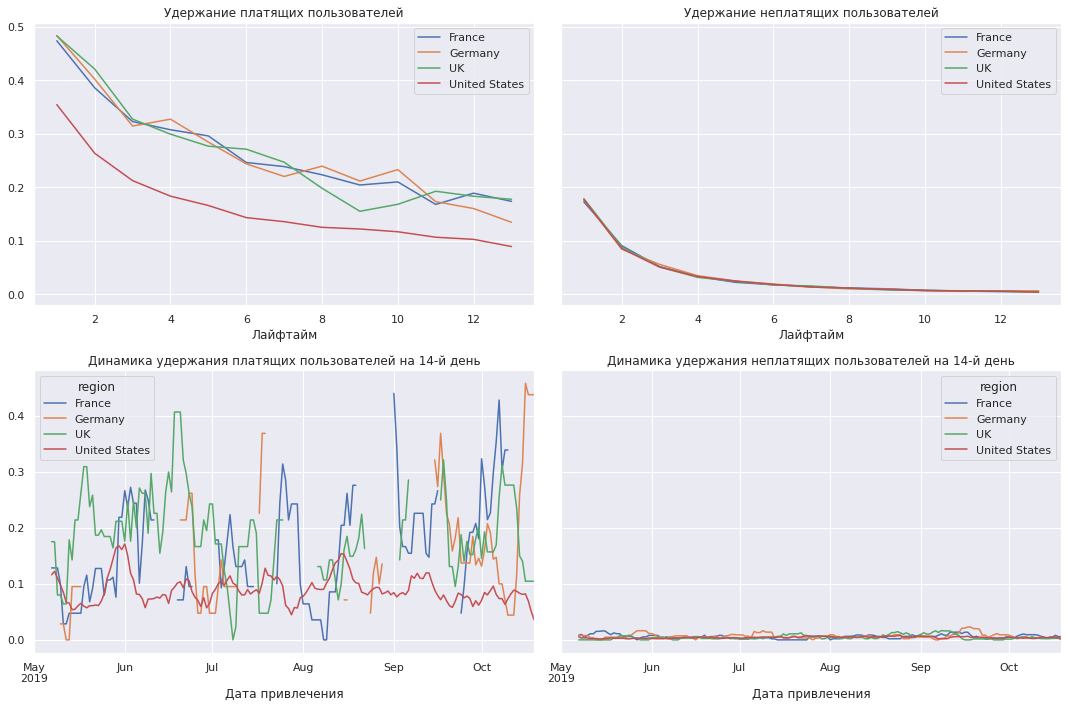

In [42]:
# смотрим удержание с разбивкой по странам
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Да пользователи из США лучше конвертируются и больше платят, за это рекламодатели берут больше за рекламу в США, но видимо не учитывают, что удержание платящих пользователей из США значительно уступает другим странам. Теперь у нас есть аргумент договариваться с рекламодателями снижать стоимость рекламы в США.

**Проверим конверсию пользователей и динамику её изменения с разбивкой по каналам привлечения. То же самое сделаем с удержанием пользователей.**

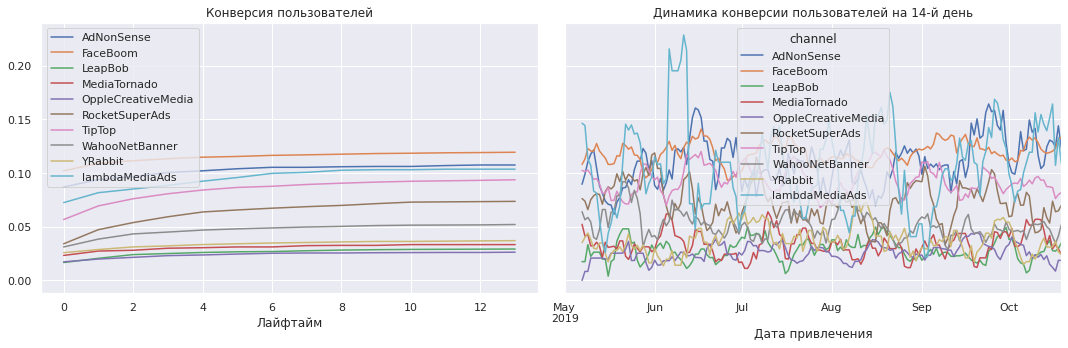

In [43]:
# смотрим конверсию с разбивкой по источникам привлечения
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лидеhами по конверсии являются FaceBoom, AdNonSense и lambdaMediaADS.

**Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

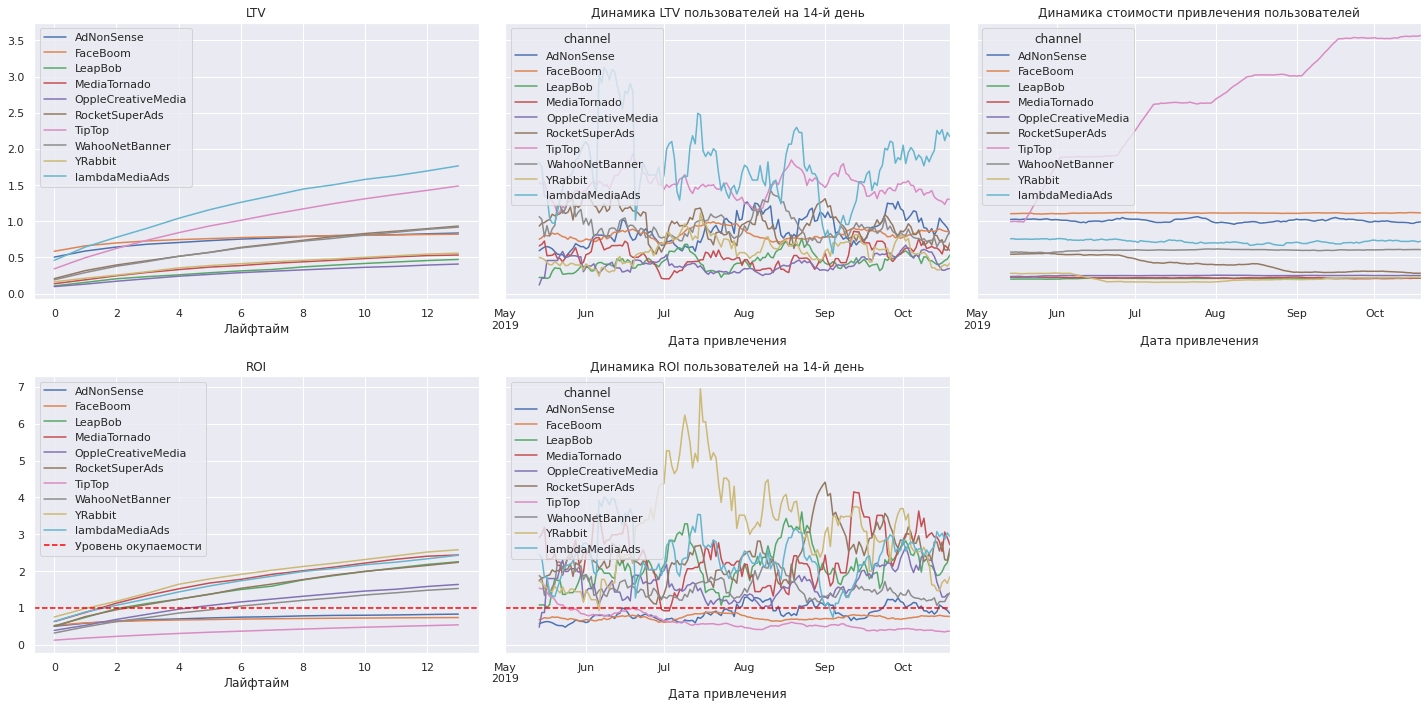

In [44]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Не окупается реклама купленная у TipTop, FaceBoom и AdNonSense. У TipTop это связано со значительным ростом стоимости привлечения со временнем, так как в самом начале ROI был больше единицы. У FaceBoom и AdNonSense LTV и CAC стабильны, значит изначально был ошибочно рассчитан срок окупаемости от этих каналов.  

**Построим удержание с разбивкой по каналам привлечения**

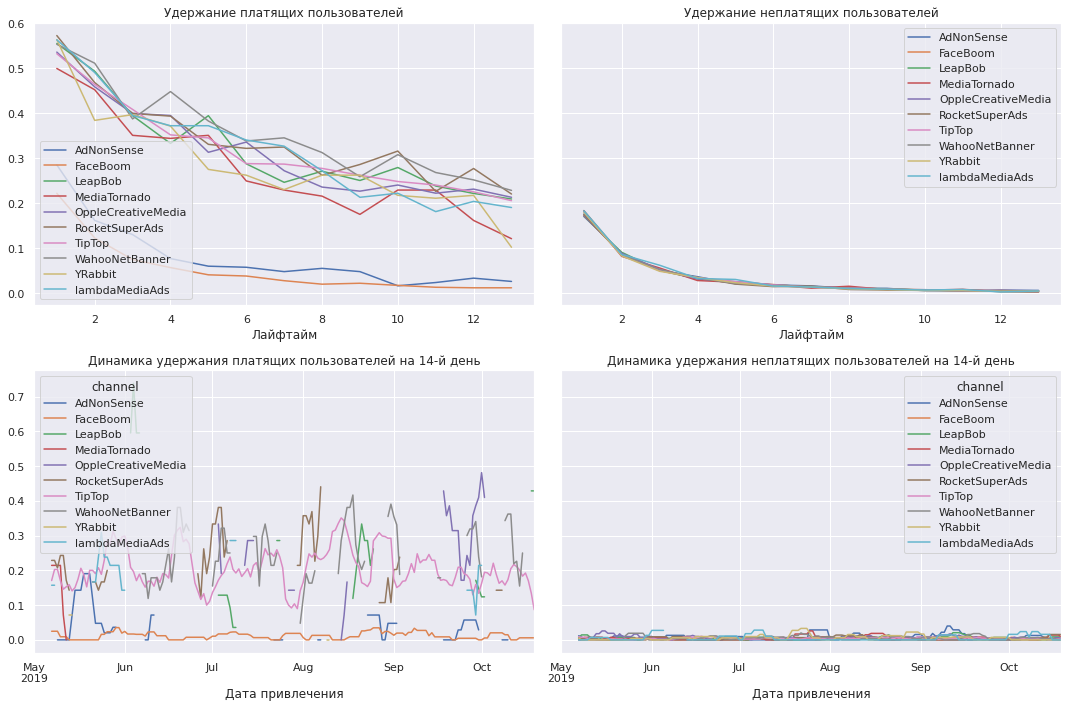

In [45]:
# смотрим удержание с разбивкой по каналам
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Показав наши результататы FaceBoom и AdNonSense, можем договариваться с ними о снижении стоимости рекламы, так как пользователи с этих каналов значительно хуже удерживаются по сравнению с пользователями из других каналов привлечения.

### Общий вывод

В нашем приложении основная часть пользователей из США, если брать платящих пользователей то пользователи из США состовляют более 75% от общего числа. Распределение по устройствам равномерное. Из FaceBoom привлечено 40% платящих пользователей, из TipTop 21%, органических - 13%. Больше поливины рекламного бюджета уходит на TipTop, 30% на FaceBoom. Реклама не окупается, LTV стабилен, CAC растет.

Анализ по устройствам не выявил причин проблем. У всех устройств стабильный LTV с течением времени и и у всех тенденция на увеличение CAC.

Анализ по странам показал, что пользователи из Европы приносят хорошие деньги за небольшие затраты (CAC стабилен). Бизнес в Европе показывает хорошую доходность, что нельзя сказать по США. В США рекламодатели сильно переоценивают качество пользователей (да они больше платят и лучше конвертируются, чем в Европе), но сильный рост CAC нивелирует все эти преимущества, к тому же пользователи из США хуже удерживаются.

Анализ по каналам привлеченим выявил, что для каналов FaceBoom и AdNonSense неверно был расчитан срок окупаемости изначально. Пользователи из этих каналов имеют хорошую конвертацию,но денег приносят меньше, чем мы платим за рекламу и за две недели не успевают окупить своё привлечение. Пользователи из TipTop сначала окупали своё привлечение, однако реклама на платформе дорожает сильно и часто и пользователи привлеченные из TipTop стали для нас "золотыми".

Рекомендации:
- Дивесицировать пользователей по странам (слишком большой процент пользователей из США).
- Договариваться о снижении стоимости рекламы в США до адекватных значений (аргумент - пользователи из США слишком плохо удерживаются, они переоценены).
- Попробовать договориться о снижении стоимости рекламы у FaceBoom, AdNonSense (аргумент - слишком плохо удерживаются).
- Рассмотреть отказ от рекламы в TipTop, так как стоимость необоснованно дорогая.
- Деверсифицировать расходы на рекламу. Хочу отметить lambdaMediaAds, которые имеют хорошую конвертацию, пользователи платежеспособны и хорошо удерживаются.